# Numba vs Numpy - some sums

[Numba] is open-source optimizing compiler for Python. It seems work like magic: just add a simple decorator to your pure-python function, and it immediately becomes 200 times faster -- at least, so claims the [Wikipedia article about Numba]. Even this is hard to believe, but Wikipedia goes further and claims that a vary naive implementation of a sum of a numpy array is 30% faster then `numpy.sum`. Somehow, I would expect that `numpy.sum` is as optimized as it can be, so this claim sounds even more ambitious. Let's check this with some benchmarks!

[Numba]: http://numba.pydata.org/
[Wikipedia article about Numba]: https://en.wikipedia.org/w/index.php?title=Numba&oldid=831668946

##  System setup

As usual, I'm working on my Lenovo T440p laptop running AltLinux. It has mobile Haswell processor with 2 cores and 4 hardware threads. To make benchmarks more reproducible, I've disabled TurboBoost and locked scaling to almost 2 GHz (~1995).

In [1]:
%%sh
uname -a

Linux imelnikov.localdomain 4.14.24-un-def-alt0.M80P.1 #1 SMP PREEMPT Tue Mar 6 15:00:33 UTC 2018 x86_64 GNU/Linux


In [2]:
%%sh
cat /proc/cpuinfo | egrep '^model name|Hz'

model name	: Intel(R) Core(TM) i5-4300M CPU @ 2.60GHz
cpu MHz		: 1995.544
model name	: Intel(R) Core(TM) i5-4300M CPU @ 2.60GHz
cpu MHz		: 1995.545
model name	: Intel(R) Core(TM) i5-4300M CPU @ 2.60GHz
cpu MHz		: 1995.545
model name	: Intel(R) Core(TM) i5-4300M CPU @ 2.60GHz
cpu MHz		: 1995.543


Let's import some modules and check the versions:

In [3]:
import sys
import numba
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
print("python version:", ''.join(sys.version.splitlines()))
print("numpy version:", np.__version__)
print("numba version:", numba.__version__)

python version: 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 18:10:19) [GCC 7.2.0]
numpy version: 1.14.0
numba version: 0.36.2


In [5]:
np.random.seed(42)

## System under test

Here is the code from Wikipedia:

In [6]:
def sum1d(my_double_array):
    total = 0.0
    for i in range(my_double_array.shape[0]):
        total += my_double_array[i]
    return total

Numba's `jit` is intended to be used as decorator, but we're going to call it explicitly to make sure we run the same code with and without jit:

In [7]:
sum1d_jit = numba.jit(nopython=True)(sum1d)

In [8]:
sum1d_jit

CPUDispatcher(<function sum1d at 0x7fb4eee77158>)

We'll also check if parallelization will make any difference for us:

In [9]:
sum1d_par = numba.jit(nopython=True, parallel=True)(sum1d)

Let's run a quick test to make sure we've done everything correctly, and to force numba to compile `float64` version of our `sum1d`:

In [10]:
sample_data = np.random.randn(42)

In [11]:
sum1d(sample_data), sum1d_jit(sample_data), sum1d_par(sample_data), np.sum(sample_data)

(-7.835638675532193,
 -7.835638675532193,
 -7.835638675532193,
 -7.835638675532195)

It's interesting: naive python version and jitted version return the same number exactly, but `numpy.sum` apparently calculates things in a bit differntly.

## Measurements

We'll make a few runs for various array sizes:

In [12]:
measures = 13
sizes = 4 ** np.arange(measures)

We'll save the average runtime here:

In [13]:
res_numpy = np.zeros(measures)
res_python = np.zeros(measures)
res_numba = np.zeros(measures)
res_numba_par = np.zeros(measures)

It's time to measures all the things! This will take a few minutes:

In [14]:
%%time
for idx, size in enumerate(sizes):
    print("size =", size)
    data = np.random.randn(size).astype('f8')
    res = %timeit -o np.sum(data)
    res_numpy[idx] = res.average
    res = %timeit -o sum1d(data)
    res_python[idx] = res.average
    res = %timeit -o sum1d_jit(data)
    res_numba[idx] = res.average
    res = %timeit -o sum1d_par(data)
    res_numba_par[idx] = res.average
del data

size = 1
5.53 µs ± 298 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.04 µs ± 93.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
448 ns ± 8.96 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
469 ns ± 19.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
size = 4
4.07 µs ± 182 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.6 µs ± 26.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
473 ns ± 6.14 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
453 ns ± 6.65 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
size = 16
4.17 µs ± 205 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.35 µs ± 172 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
526 ns ± 77.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
585 ns ± 26 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
size = 64
4.54 µs ± 418 ns per loop (mean ± std. dev. of 7 runs, 100000 loops

## Looking at the data

First, let's look at various speedups and slowdowns:

In [15]:
numba_vs_naive = res_python / res_numba
numba_vs_naive.max()

192.3750032906321

Well, it's not 200 times as Wikipedia claimed, but it's pretty much close to it.

In [16]:
numba_vs_numpy = res_numba / res_numpy
numba_vs_numpy.min(), numba_vs_numpy.max()

(0.08103373848130296, 2.505059846262734)

Numba can be 2.5 times slower then numpy, but it can also be faster. Let's look at the graphs below.

In [17]:
numba_vs_par = res_numba / res_numba_par
numba_vs_par.min(), numba_vs_par.max()

(0.8986877079731856, 1.0664777926145088)

Apparently, numba cannot parallelize our function -- it's too naive for that. Let's look how speedups/slowdowns change with the array size:

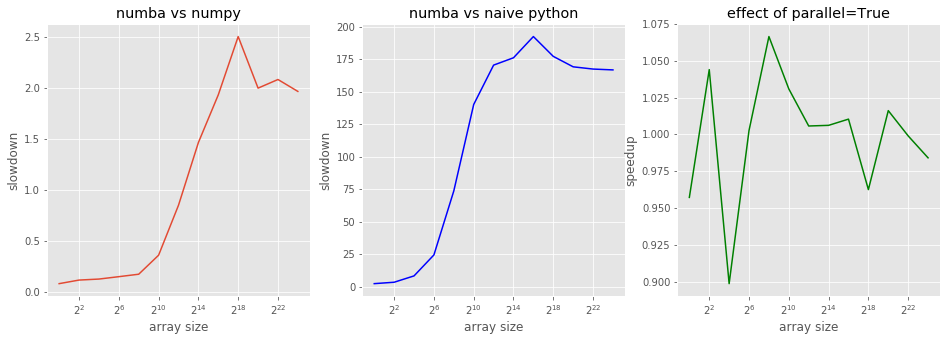

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

fig.set_size_inches(16, 5)

ax1.set_title('numba vs numpy')
ax1.set_xlabel('array size')
ax1.set_ylabel('slowdown')
ax1.semilogx(sizes, numba_vs_numpy, basex=2);


ax2.set_title('numba vs naive python')
ax2.set_xlabel('array size')
ax2.set_ylabel('slowdown')
ax2.semilogx(sizes, numba_vs_naive, basex=2, color='b');

ax3.set_title('effect of parallel=True')
ax3.set_xlabel('array size')
ax3.set_ylabel('speedup')
ax3.semilogx(sizes, numba_vs_par, basex=2, color='g');

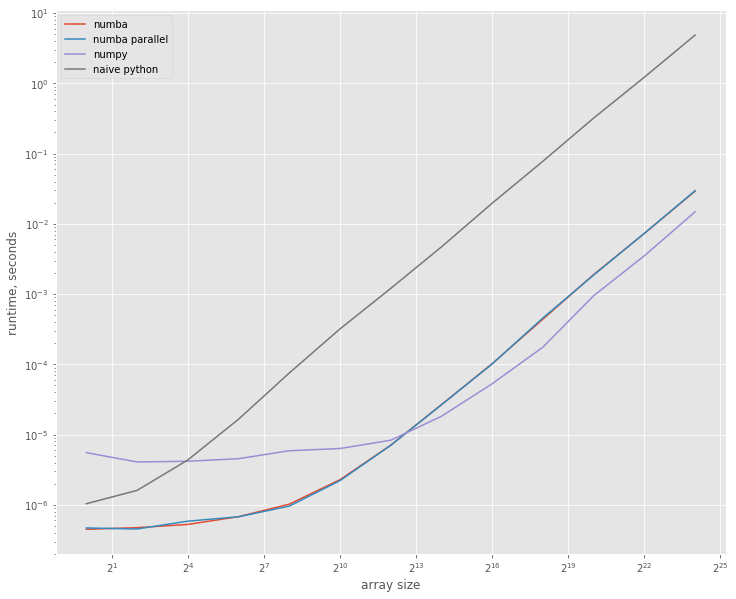

In [19]:
plt.figure().set_size_inches(12, 10)
plt.loglog(sizes, res_numba, label='numba', basex=2)
plt.loglog(sizes, res_numba_par, label='numba parallel', basex=2)
plt.loglog(sizes, res_numpy, label='numpy', basex=2)
plt.loglog(sizes, res_python, label='naive python', basex=2)
plt.xlabel("array size")
plt.ylabel("runtime, seconds");
plt.legend();

The jitted version is more then 5 times faster on smaller arrays, but for larger arrays numpy becomes ~2.5 times faster then numba; they show similar performance when array sizes are about 4000.

## Conclusions

I consider both claims of the Wikipedia article confirmed: numba brings tremendous speedup to naive python code at the const of just one decorator (and one huge additional dependency -- the numba itself `^_-`); for arrays of quite reasonable size numba can be much faster then numpy -- e.g. for size 1024 it ~2 times faster!

This allows me to conclude that **numba is awesome**. Let's see how it will behave on more real-life projects of mine.